In [1]:
import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sympy
import datetime

# для расчетов над tdb
from pycalphad import Database, equilibrium, variables as v, binplot

# для MCMC расчетов
import pymc as pm  # пакет для MCMC расчетов 
import arviz as az # пакет для работы с типом данных arviz
import pytensor
import pytensor.tensor as pt
# import theano
# theano.config.exception_verbosity = 'high' # должно выдавать подробное описание ошибки, но не помогает

import aesara

# import seaborn as sns

# пути
cc18_path = "tdbs\CoCr-18Cac_with_new_functions.tdb"
path_sigma_fcc = 'emp_data\sigma_fcc_allibert.xls' 
path_sigma_hcp ='emp_data\sigma_hcp_allibert.xls'

print(f"Running on PyMC v{pm.__version__}") # 5.1.2
print(f"Running on NumPy v{np.__version__}") # 1.22.1
print(f"Running on ArviZ v{az.__version__}") # 0.12.1

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.3.1
Running on NumPy v1.22.1
Running on ArviZ v0.15.1


In [2]:
def from_xarray_to_pandas(xarray_data, component_str, goal_phase_str):

    import numpy as np
    
    cr_tuple = xarray_data.X.sel(component=component_str).data[0][0]
    phase_tuple = xarray_data.Phase.data[0][0]
    t_tuple = xarray_data.T.data

    df = pd.DataFrame()

    # создали таблицу со всеми данными
    for i in range(phase_tuple.shape[2]):
        df_temp = pd.DataFrame(columns=['T','num','phase','conc'])
        df_temp['T'] = t_tuple
        df_temp['phase'] = phase_tuple[:, 0, i]
        df_temp['conc'] = cr_tuple[:, 0, i]
        
        df = pd.concat([df, df_temp])

    # смерджили нужные нам данные с имеющимися температурами
    df_res = pd.DataFrame({'T': t_tuple})
    df_res = pd.merge(df_res['T']
                    , df[(df['phase'] == goal_phase_str)][['T','phase','conc']]
                    , how = 'left'
                    , left_on = 'T'
                    , right_on = 'T')

    # заменили NaN значения
    df_res['phase'].fillna(goal_phase_str, inplace=True)
    df_res['conc'].fillna(10, inplace=True)

    return df_res


# 1 Кастом независимой функции

In [3]:
# define a pytensor Op for our likelihood function
class LogLike(pt.Op):
#     определяем тип входящих и исходящих данных
    itypes = [pt.dvector]  # expects a vector of parameter values when called
    otypes = [pt.fvector]  # outputs a single scalar value (the log likelihood)

    def __init__(self, db, conditions, phase, elements, component, parameters_list):
        self.db_tdb = db
        self.conditions_dict = conditions
        self.phases_list = list(self.db_tdb.phases.keys())
        self.phase_str = phase
        self.elements_list = elements
        self.component_str = component
        self.parameters_list = parameters_list
        
        self.y_eqs = []
        self.likelihoods = []

    def perform(self, node, inputs, outputs):
        
        (theta,) = inputs  # this will contain my variables
        
        # новая версия
        new_parameters = dict()
        
        for i in range(len(self.parameters_list)):
            new_parameters[self.parameters_list[i]] = inputs[0][i]

        
        # старая версия
        # COCRCO_0, COCRCO_1, COCRCR_0, COCRCR_1 = theta

        # new_parameters = {
        #  'SIGMA_OLD_COCRCO_0' : COCRCO_0
        #  ,'SIGMA_OLD_COCRCO_1': COCRCO_1
        #  ,'SIGMA_OLD_COCRCR_0': COCRCR_0
        #  ,'SIGMA_OLD_COCRCR_1': COCRCR_1
        # }
        # print(new_parameters)
        
        
        y_eq = (from_xarray_to_pandas(equilibrium(self.db_tdb
                                            , self.elements_list
                                            , self.phases_list
                                            , self.conditions_dict
                                            , parameters = new_parameters
                                        ), self.component_str, self.phase_str)['conc']
                .astype(np.float32)
                .to_numpy())

        outputs[0][0] = y_eq
                             
                             

# 2 Расчет апостериорных распределений параметров

In [4]:
df_sigma_fcc = pd.read_excel(path_sigma_fcc)
# df_sigma_bcc = pd.read_excel('emp_data/sigma_bcc_allibert.xls')
df_sigma_hcp = pd.read_excel(path_sigma_hcp)

df_sigma_fcc = pd.concat([df_sigma_fcc, df_sigma_hcp])

df_sigma_fcc['T'] = df_sigma_fcc['T'].round(2)
df_sigma_fcc['cr_conc'] = df_sigma_fcc['cr_conc'].round(6)
df_sigma_fcc_sigma_old = df_sigma_fcc[(df_sigma_fcc['phase'] == 'sigma_old')].reset_index()
df_sigma_fcc_sigma_old

,index,cr_conc,T,phase
0,6,0.532019,1321.35,sigma_old
1,7,0.542469,1226.97,sigma_old
2,8,0.547749,1471.91,sigma_old
3,9,0.554050,1370.79,sigma_old
4,10,0.556156,1269.66,sigma_old
5,11,0.559283,1422.47,sigma_old
6,7,0.541762,928.09,sigma_old
7,8,0.545313,1020.22,sigma_old
8,9,0.551960,1069.66,sigma_old
9,10,0.558231,973.03,sigma_old


In [5]:
db10 = Database(cc18_path)

phases10 = list(db10.phases.keys())
press = 101325
elements = ['CR', 'CO', 'VA']
component = 'CR'
el_cnt = 1

df_sigma_fcc_sigma_old = df_sigma_fcc_sigma_old.sort_values('T')

T = df_sigma_fcc_sigma_old['T'].to_numpy()
phase = 'SIGMA_D8B'

y_obs = df_sigma_fcc_sigma_old['cr_conc'].values
conditions = {v.X('CR'):0.5, v.P: 101325, v.T: T, v.N: el_cnt}
parameters_list = ['GSCRCO1', 'GSCOCRCO1', 'GSCOCRCO2', 'GSCRCO2', 'GSCOCR1',  'GSCOCR2', 'GSCOCR3']

print('T', T)
print('y_obs', y_obs)
print('phase', phase)

T [ 928.09  973.03 1020.22 1069.66 1121.35 1168.54 1217.98 1226.97 1269.66
 1321.35 1370.79 1422.47 1471.91]
y_obs [0.541762 0.558231 0.545313 0.55196  0.559991 0.565255 0.560713 0.542469
 0.556156 0.532019 0.55405  0.559283 0.547749]
phase SIGMA_D8B


In [6]:
pytensor.config.exception_verbosity = 'high'
import psutil

test_model = pm.Model()

logl = LogLike(db10, conditions, phase, elements, component, parameters_list)

with test_model:
    # uniform priors on m and c
    GSCRCO1 = pm.Normal("GSCRCO1", mu=-526000.0, sigma=1)
    GSCOCRCO1 = pm.Normal("GSCOCRCO1", mu=-200000.0, sigma=1)
    GSCOCRCO2 = pm.Normal("GSCOCRCO2", mu=20.0, sigma=1)
    GSCRCO2 = pm.Normal("GSCRCO2", mu=49.0, sigma=1) 
    GSCOCR1 = pm.Normal("GSCOCR1", mu=180000.0, sigma=1) 
    GSCOCR2 = pm.Normal("GSCOCR2", mu=348000.0, sigma=1) 
    GSCOCR3 = pm.Normal("GSCOCR3", mu=525000.0, sigma=1) 
    
    theta = pt.as_tensor_variable([GSCRCO1, GSCOCRCO1, GSCOCRCO2, GSCRCO2, GSCOCR1,  GSCOCR2, GSCOCR3])
    # y_det = pm.Deterministic("y_det", logl(theta))
    y_norm = pm.Normal("y_norm", mu=logl(theta), sigma = 0.001, observed=y_obs)

    pp = pm.sample_prior_predictive(samples=2000)


Sampling: [GSCOCR1, GSCOCR2, GSCOCR3, GSCOCRCO1, GSCOCRCO2, GSCRCO1, GSCRCO2, y_norm]


KeyboardInterrupt: 

In [ ]:
pp.to_json('calc_res\pp_cocr18_700x1000x2_18.json')

In [ ]:
with test_model:
    trace = pm.sample(1000, tune=700, chains=2, idata_kwargs={"log_likelihood": True})


In [ ]:
trace.to_json('calc_res\trace_cocr18_700x1000x2_18.json')

array([[<Axes: title={'center': 'GSCRCO1'}>,
        <Axes: title={'center': 'GSCRCO1'}>],
       [<Axes: title={'center': 'GSCOCRCO1'}>,
        <Axes: title={'center': 'GSCOCRCO1'}>],
       [<Axes: title={'center': 'GSCOCRCO2'}>,
        <Axes: title={'center': 'GSCOCRCO2'}>],
       [<Axes: title={'center': 'GSCRCO2'}>,
        <Axes: title={'center': 'GSCRCO2'}>],
       [<Axes: title={'center': 'GSCOCR1'}>,
        <Axes: title={'center': 'GSCOCR1'}>],
       [<Axes: title={'center': 'GSCOCR2'}>,
        <Axes: title={'center': 'GSCOCR2'}>],
       [<Axes: title={'center': 'GSCOCR3'}>,
        <Axes: title={'center': 'GSCOCR3'}>]], dtype=object)

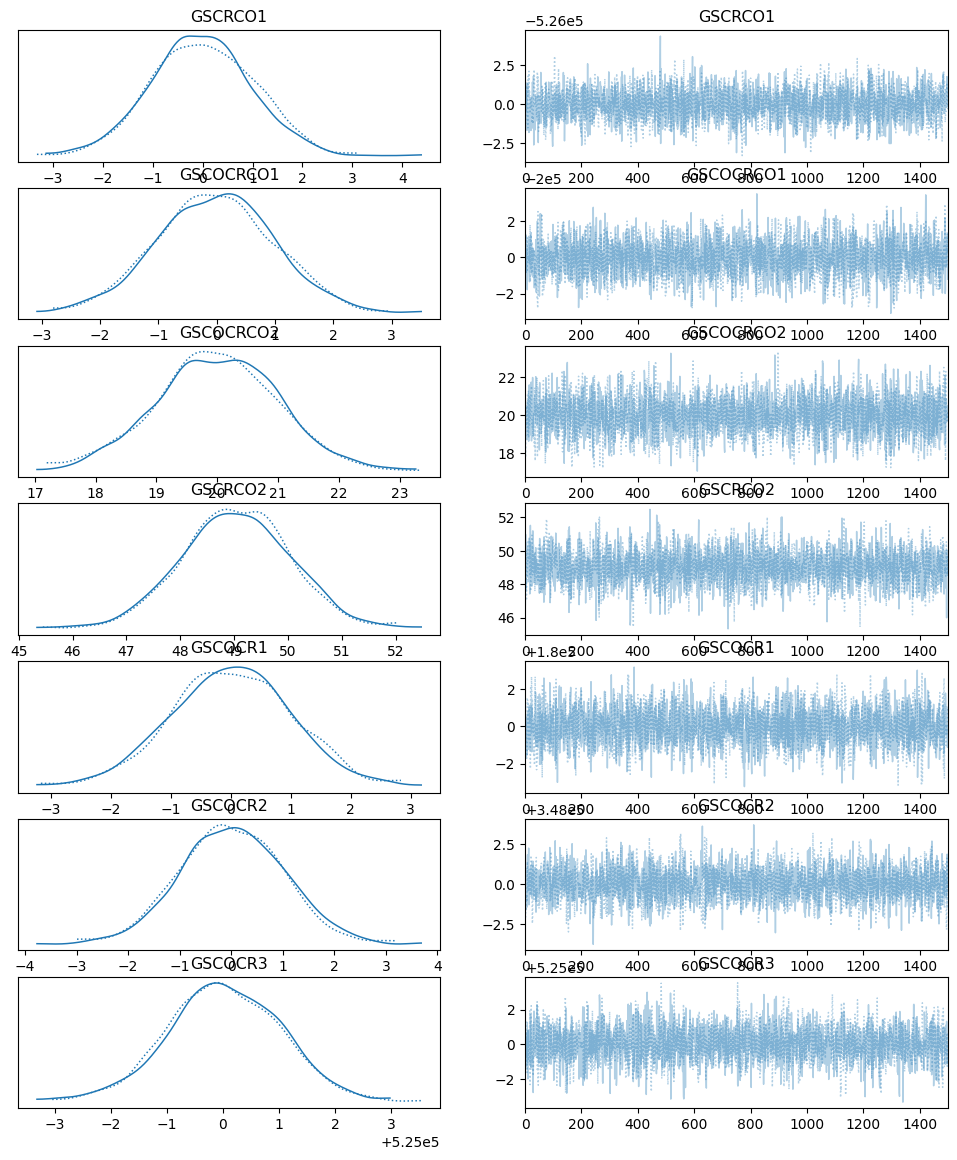

In [ ]:
az.plot_trace(trace)

In [ ]:
with test_model:
    ppc = pm.sample_posterior_predictive(trace)

In [ ]:
ppc.to_json('calc_res\ppc_cocr18_700x1000x2.json')